In [278]:
from matplotlib.pyplot import scatter, title, xlabel, ylabel, figure, title, plot, show, axvline
from pandas import read_csv, DataFrame
from numpy import min
from seaborn import heatmap, scatterplot
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [279]:
# Read csv file 
packages_df = read_csv("https://raw.githubusercontent.com/Pfob/ClusteringScikitLearn/main/datasets/Packst%C3%BCcke.csv", sep=";", header=0)  

# Show first ten rows of dataframe 
packages_df.head(10)

,Package No,Shipment No,Gross Weight (kg),Width (cm),Height (cm),Length (cm)
0,1007530-2011-03239,1000088,23,35,30,35
1,1007530-2011-03241,1000310,150,60,55,80
2,1007530-2011-03242,1000346,"0,5",14,15,19
3,1007530-2011-03243,1000456,"1,5",20,20,29
4,1007530-2011-03244,1000796,1,10,10,10
5,1007530-2011-03245,1000957,75,82,81,120
6,1007530-2011-03246,1000957,41,80,34,120
7,1007530-2011-03247,1001184,1.340,220,112,406
8,1007530-2011-03249,1001408,"0,5",20,20,29
9,1007530-2011-03250,1001563,5,45,35,45


In [280]:
# Show data types of columns
packages_df.dtypes

Package No           object
Shipment No           int64
Gross Weight (kg)    object
Width (cm)           object
Height (cm)           int64
Length (cm)           int64
dtype: object

Text(0, 0.5, 'Length (cm)')

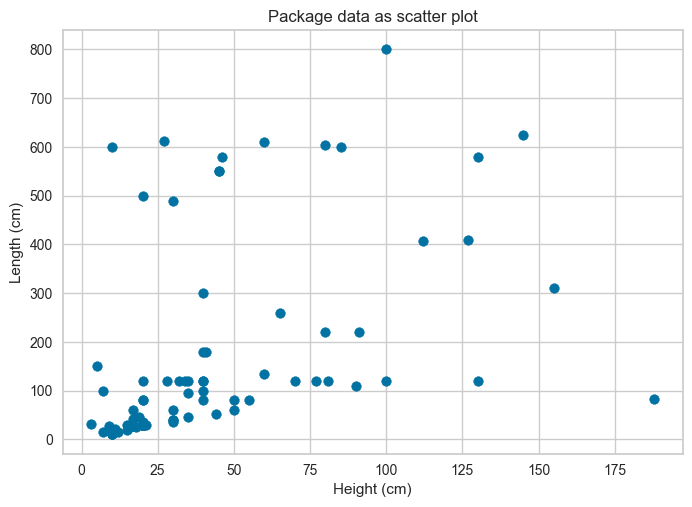

In [281]:
# Plot data as scatter  
scatter(packages_df["Height (cm)"].to_numpy(), packages_df["Length (cm)"].to_numpy())
title("Package data as scatter plot")
xlabel("Height (cm)")
ylabel("Length (cm)")

In [282]:
# Replace "," with "." (us standard)
packages_df["Gross Weight (kg)"] = packages_df.apply(lambda row: str(row["Gross Weight (kg)"]).replace(".", "").replace(",", "."), axis=1)
packages_df["Width (cm)"] = packages_df.apply(lambda row: str(row["Width (cm)"]).replace(".", "").replace(",", "."), axis=1)

# Convert to correct data type
packages_df[["Gross Weight (kg)", "Width (cm)"]] = packages_df[["Gross Weight (kg)", "Width (cm)"]].astype(float)
packages_df[["Height (cm)", "Length (cm)"]] = packages_df[["Height (cm)", "Length (cm)"]].astype(int)
packages_df[["Package No", "Shipment No"]] = packages_df[["Package No", "Shipment No"]].astype(str)

# Calculate volume of each row
packages_df["Volume (m³)"] = packages_df.apply(lambda row: row["Width (cm)"] * row["Height (cm)"] * row["Length (cm)"] / 1000000, axis=1)

# Drop not needed cols
x = packages_df.drop(["Package No", "Shipment No", "Width (cm)", "Height (cm)", "Length (cm)"], axis=1)

# Show first ten rows of dataframe 
x.head(10)

,Gross Weight (kg),Volume (m³)
0,23.0,0.036750
1,150.0,0.264000
2,0.5,0.003990
3,1.5,0.011600
4,1.0,0.001000
5,75.0,0.797040
6,41.0,0.326400
7,1340.0,10.003840
8,0.5,0.011600
9,5.0,0.070875


Text(0, 0.5, 'Volume (m³)')

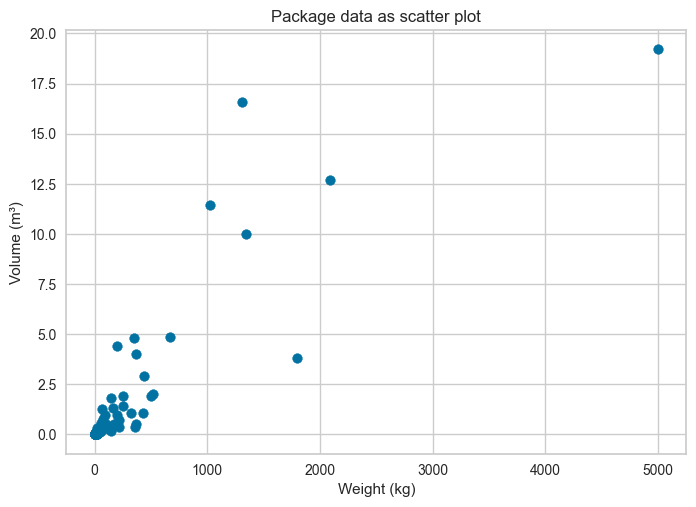

In [283]:
# Plot data as scatter  
scatter(x["Gross Weight (kg)"].to_numpy(), x["Volume (m³)"].to_numpy())
title("Package data as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")

Text(0, 0.5, 'Volume (m³)')

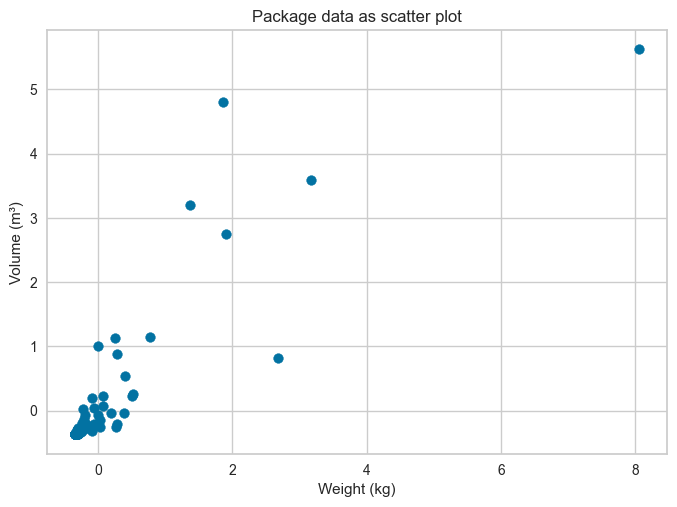

In [284]:
# Normalize data
scaler = preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(x)
scaled_weight = scaled_x[:, :1]
scaled_volume = scaled_x[:, 1:2]

# Plot data as scatter  
scatter(scaled_weight, scaled_volume)
title("Package data as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")

# kMeans

C:\Users\mario\AppData\Local\Temp\ipykernel_2948\2463927229.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_kmeans_scores = df_kmeans_scores.pivot("Cluster seed selection & algorithm", "Number of clusters", "score")


<AxesSubplot: title={'center': 'Comparison of cluster seed selection, k-means algorithm and increasing number of clusters'}, xlabel='Number of clusters', ylabel='Cluster seed selection & algorithm'>

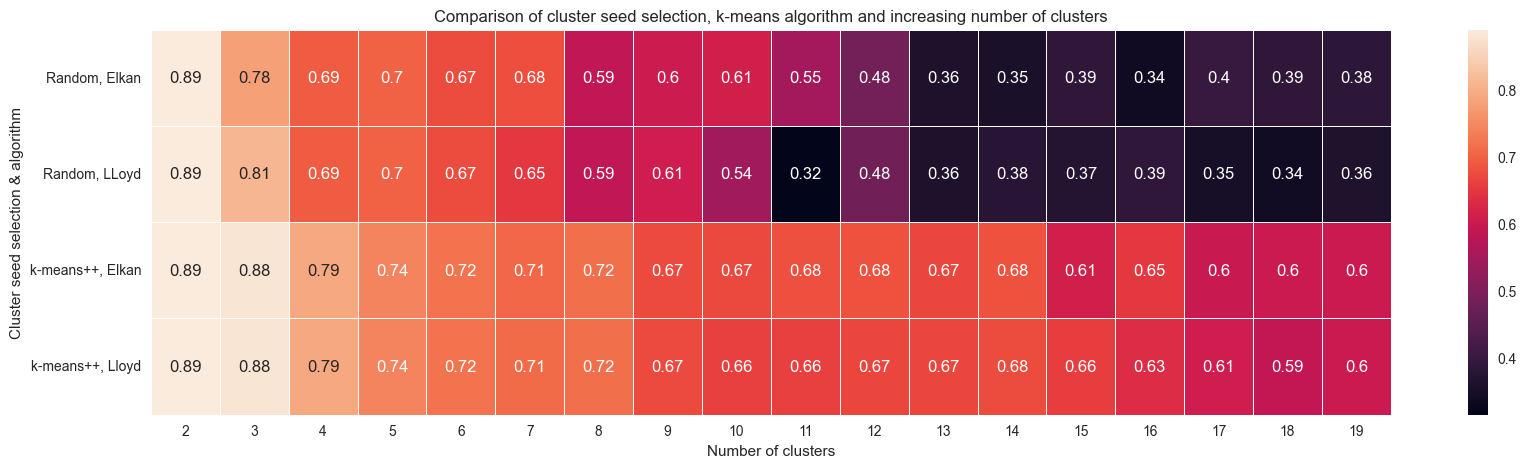

In [285]:
# create clusters via k-means for random and k-means++ cluster seeds for lloyds and elkan algorithm
kmeans_scores = []
for i in range(2, 20):
    y_cluster_random_lloyd = KMeans(n_clusters=i, init="random", algorithm="lloyd").fit_predict(scaled_x)
    y_cluster_random_elkan = KMeans(n_clusters=i, init="random", algorithm="elkan").fit_predict(scaled_x)

    y_cluster_kmeans_lloyd = KMeans(n_clusters=i, init="k-means++", algorithm="lloyd").fit_predict(scaled_x)
    y_cluster_kmeans_elkan = KMeans(n_clusters=i, init="k-means++", algorithm="elkan").fit_predict(scaled_x)

    kmeans_scores.append({"Cluster seed selection & algorithm": "Random, LLoyd", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_random_lloyd, metric="euclidean")})
    kmeans_scores.append({"Cluster seed selection & algorithm": "Random, Elkan", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_random_elkan, metric="euclidean")})

    kmeans_scores.append({"Cluster seed selection & algorithm": "k-means++, Lloyd", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_kmeans_lloyd, metric="euclidean")})
    kmeans_scores.append({"Cluster seed selection & algorithm": "k-means++, Elkan", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_kmeans_elkan, metric="euclidean")})


df_kmeans_scores = DataFrame(kmeans_scores)
df_kmeans_scores = df_kmeans_scores.pivot("Cluster seed selection & algorithm", "Number of clusters", "score")

# Plot comparison
figure(figsize = (20,5))
title("Comparison of cluster seed selection, k-means algorithm and increasing number of clusters")
heatmap(df_kmeans_scores, annot=True, linewidth=.5)

c:\Users\mario\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


Text(0, 0.5, 'Volume (m³)')

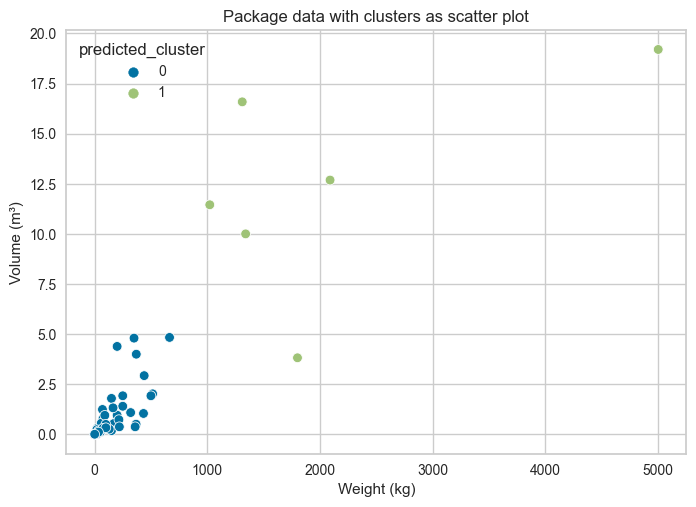

In [286]:
# Define 2 Clusters with k-means++ and Elkan algorithm
kmeans = KMeans(n_clusters=2, algorithm="elkan")

# Prediction via K-Means
y_kmeans = kmeans.fit_predict(scaled_x)

# Visualize allocation of datapoints
x["predicted_cluster"] = y_kmeans.astype(int)
scatterplot(x="Gross Weight (kg)", y="Volume (m³)", hue="predicted_cluster", data=x, cmap="rainbow")
title("Package data with clusters as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")

# Hierachical

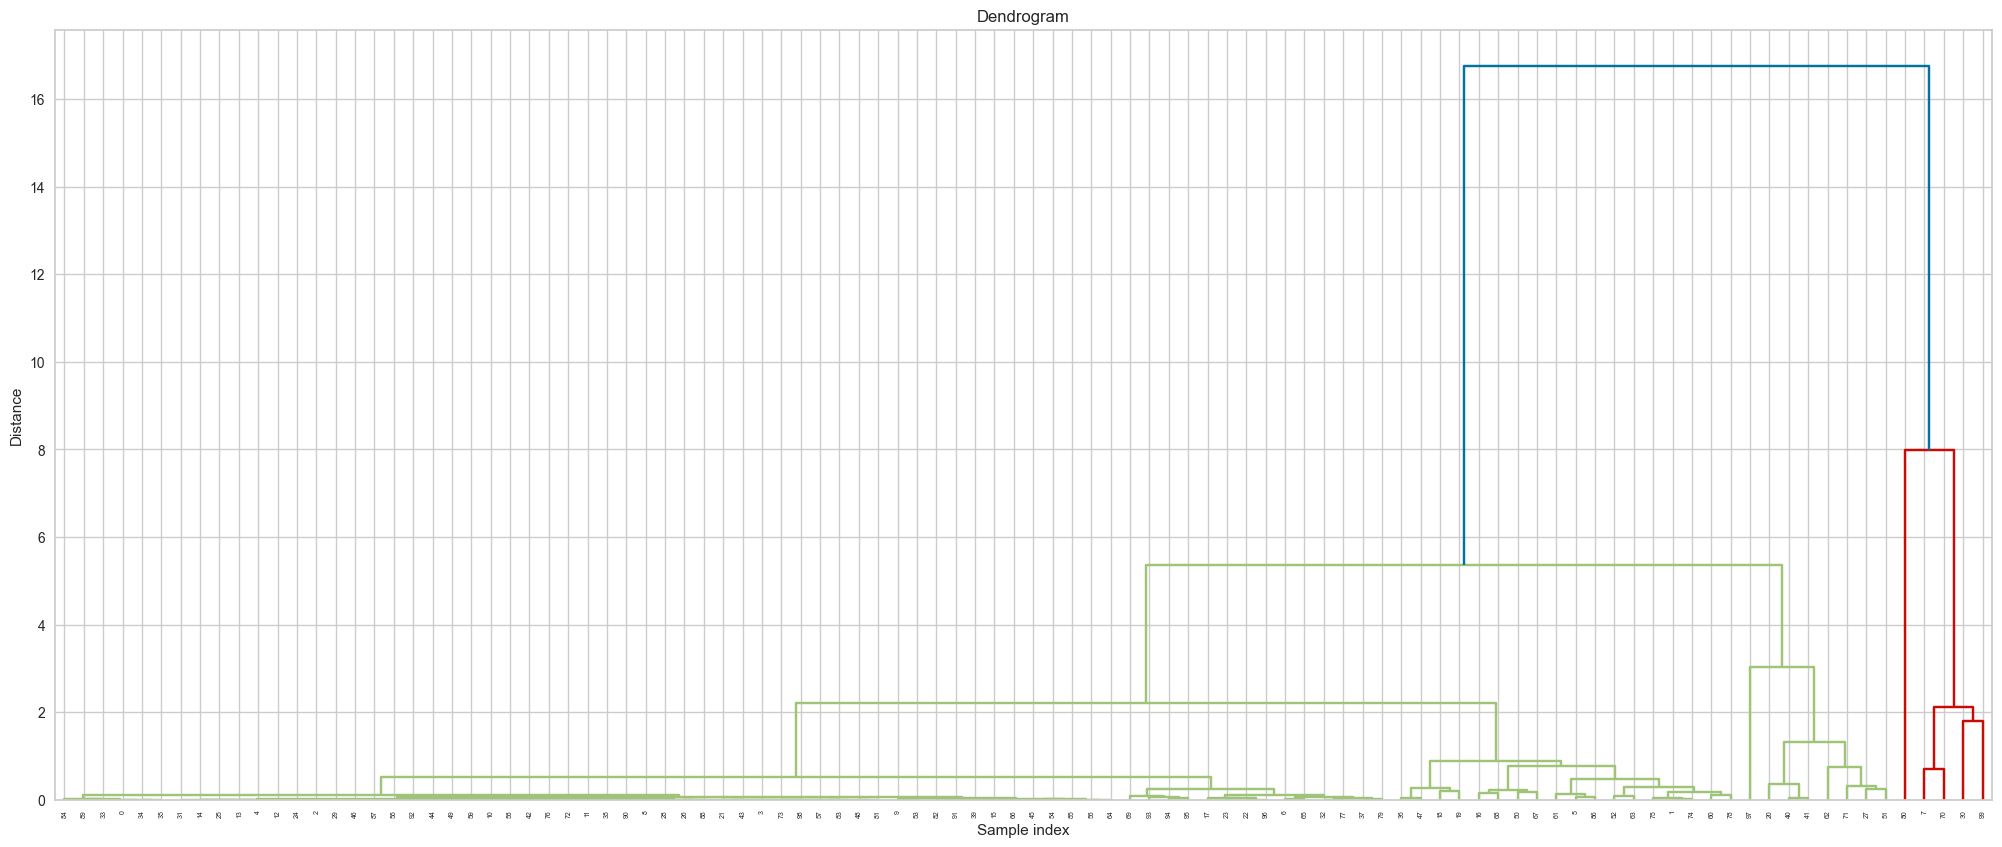

In [287]:
# Plot dendrogram
figure(figsize=(25, 10))
title("Dendrogram")
xlabel("Sample index")
ylabel("Distance")
dend = dendrogram(linkage(scaled_x, method="ward"))

C:\Users\mario\AppData\Local\Temp\ipykernel_2948\1736319244.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_scores = df_scores.pivot("Distance- & Linkage-Method", "Number of clusters", "score")


<AxesSubplot: title={'center': 'Comparison of distance, linkage methods and increasing number of clusters'}, xlabel='Number of clusters', ylabel='Distance- & Linkage-Method'>

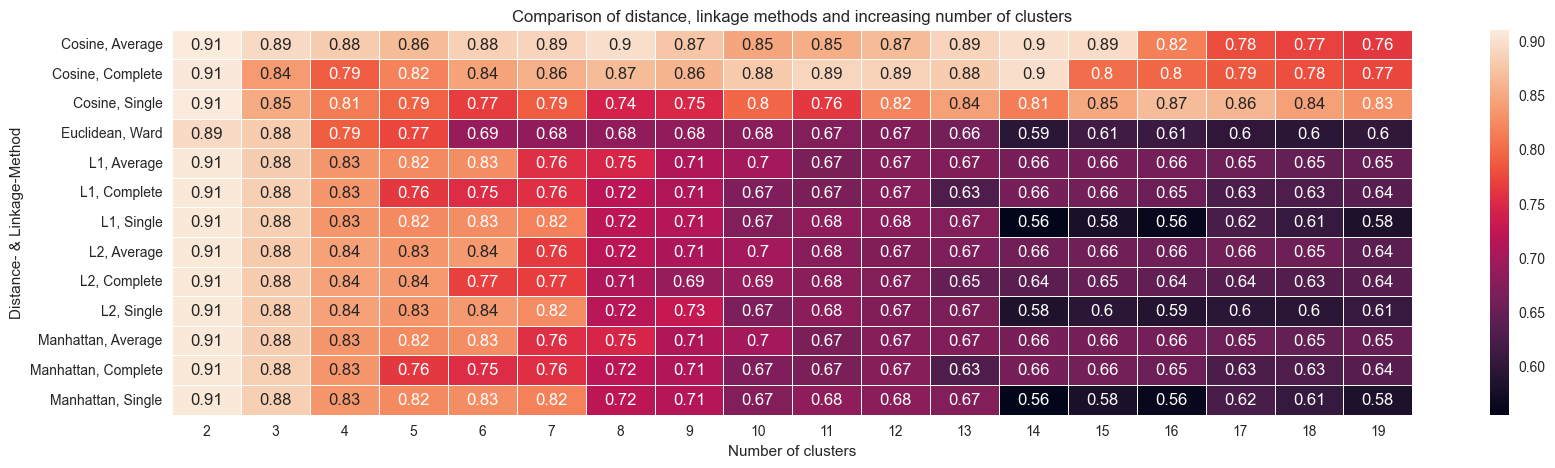

In [288]:
# Build agglomerative clusters and compare by affinity, linkage method and by amount of clusters (through silhouette score)
scores = []
for i in range(2, 20):
    y_cluster_euc_war = AgglomerativeClustering(n_clusters=i, affinity="euclidean", linkage="ward").fit_predict(scaled_x)

    y_cluster_l1_com = AgglomerativeClustering(n_clusters=i, affinity="l1", linkage="complete").fit_predict(scaled_x)
    y_cluster_l1_avg = AgglomerativeClustering(n_clusters=i, affinity="l1", linkage="average").fit_predict(scaled_x)
    y_cluster_l1_sin = AgglomerativeClustering(n_clusters=i, affinity="l1", linkage="single").fit_predict(scaled_x)

    y_cluster_l2_com = AgglomerativeClustering(n_clusters=i, affinity="l2", linkage="complete").fit_predict(scaled_x)
    y_cluster_l2_avg = AgglomerativeClustering(n_clusters=i, affinity="l2", linkage="average").fit_predict(scaled_x)
    y_cluster_l2_sin = AgglomerativeClustering(n_clusters=i, affinity="l2", linkage="single").fit_predict(scaled_x)

    y_cluster_man_com = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="complete").fit_predict(scaled_x)
    y_cluster_man_avg = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="average").fit_predict(scaled_x)
    y_cluster_man_sin = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="single").fit_predict(scaled_x)

    y_cluster_cos_com = AgglomerativeClustering(n_clusters=i, affinity="cosine", linkage="complete").fit_predict(scaled_x)
    y_cluster_cos_avg = AgglomerativeClustering(n_clusters=i, affinity="cosine", linkage="average").fit_predict(scaled_x)
    y_cluster_cos_sin = AgglomerativeClustering(n_clusters=i, affinity="cosine", linkage="single").fit_predict(scaled_x)


    scores.append({"Distance- & Linkage-Method": "Euclidean, Ward", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_euc_war, metric="euclidean")})
    
    scores.append({"Distance- & Linkage-Method": "L1, Complete", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_l1_com, metric="l1")})
    scores.append({"Distance- & Linkage-Method": "L1, Average", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_l1_avg, metric="l1")})
    scores.append({"Distance- & Linkage-Method": "L1, Single", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_l1_sin, metric="l1")})

    scores.append({"Distance- & Linkage-Method": "L2, Complete", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_l2_com, metric="l2")})
    scores.append({"Distance- & Linkage-Method": "L2, Average", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_l2_avg, metric="l2")})
    scores.append({"Distance- & Linkage-Method": "L2, Single", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_l2_sin, metric="l2")})

    scores.append({"Distance- & Linkage-Method": "Manhattan, Complete", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_man_com, metric="manhattan")})
    scores.append({"Distance- & Linkage-Method": "Manhattan, Average", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_man_avg, metric="manhattan")})
    scores.append({"Distance- & Linkage-Method": "Manhattan, Single", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_man_sin, metric="manhattan")})

    scores.append({"Distance- & Linkage-Method": "Cosine, Complete", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_cos_com, metric="cosine")})
    scores.append({"Distance- & Linkage-Method": "Cosine, Average", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_cos_avg, metric="cosine")})
    scores.append({"Distance- & Linkage-Method": "Cosine, Single", "Number of clusters": i, "score": silhouette_score(scaled_x, y_cluster_cos_sin, metric="cosine")})

df_scores = DataFrame(scores)
df_scores = df_scores.pivot("Distance- & Linkage-Method", "Number of clusters", "score")

# Plot comparison
figure(figsize = (20,5))
title("Comparison of distance, linkage methods and increasing number of clusters")
heatmap(df_scores, annot=True, linewidth=.5)

c:\Users\mario\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


Text(0, 0.5, 'Volume (m³)')

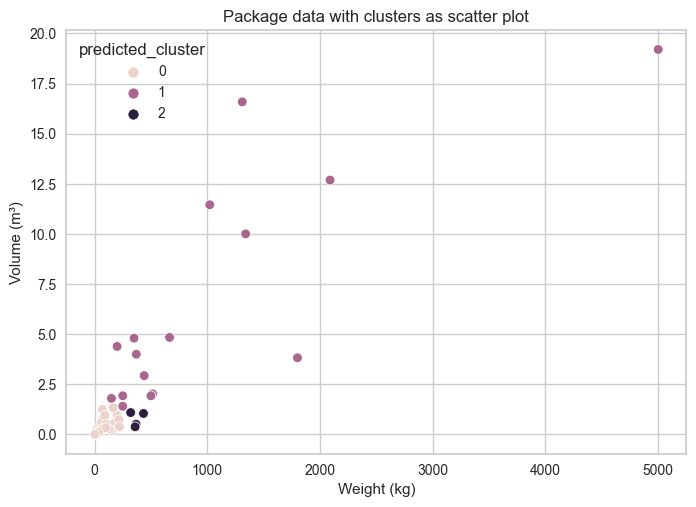

In [290]:
# Plot final cluster decision
cluster_final = AgglomerativeClustering(n_clusters=2, affinity="l1", linkage="single")
y_cluster_final = cluster_final.fit_predict(scaled_x)
x["predicted_cluster"] = y_cluster_final.astype(int)
scatterplot(x="Gross Weight (kg)", y="Volume (m³)", hue="predicted_cluster", data=x, cmap="rainbow")
title("Package data with clusters as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")